In [10]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set your W&B API key here or ensure it's set in your environment
# wandb.login(key="YOUR_WANDB_API_KEY")

# --- Data Download Section ---

def download_wandb_data(entity, project, boxes_list, range_list, eval_keys, grid=5, run_name=None):
    """
    Download W&B run histories for all (boxes, range) combinations.
    Returns a nested dict: data[boxes][range] = list of DataFrames (one per run/seed)
    """
    api = wandb.Api()
    data = {}
    for boxes in boxes_list:
        print(f"Downloading data for boxes: {boxes}")
        data[boxes] = {}
        for rng in range_list:
            print(f"Downloading data for boxes: {boxes}, range: {rng}")
            if run_name is None:
                run_name = f"moving_boxes_{boxes}_grid_{grid}_range_{rng}"
            print(f"Run name: {run_name}")
            all_runs = api.runs(f"{entity}/{project}")
            run_ids = [run.id for run in all_runs if run.name == run_name]
            dfs = []
            for run_id in run_ids:
                try:
                    run = api.run(f"{entity}/{project}/{run_id}")
                    history = run.history(keys=["epoch"] + eval_keys, pandas=True)
                    history["RunID"] = run_id
                    dfs.append(history)
                except Exception as e:
                    print(f"Could not fetch run {run_name} (id: {run_id}): {e}")
            data[boxes][rng] = dfs
    return data

# --- Plotting Section ---

def plot_metric_grid(data, boxes_list, range_list, eval_keys, metric_name="cat_acc", log_y=False):
    """
    Plot a given metric (mean ± std error) for all (boxes, range) combinations using pre-downloaded data.
    metric_name: the y-axis metric to plot (e.g., "cat_acc", "mean_reward", etc.)
    eval_keys: list of keys to plot, e.g. ["eval_1/cat_acc", ...] or ["eval_1/mean_reward", ...]
    log_y: if True, set y-axis to log scale
    """
    # Prepare 3x3 grid for plotting
    fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True, sharey=False)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)

    # Set up a viridis color palette for the eval_keys
    from matplotlib import cm
    num_keys = len(eval_keys)
    viridis = cm.get_cmap('viridis', num_keys)
    colors = [viridis(i) for i in range(num_keys)]

    for i, boxes in enumerate(boxes_list):
        for j, rng in enumerate(range_list):
            dfs = data.get(boxes, {}).get(rng, [])
            ax = axes[i, j]
            if not dfs:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=14)
                ax.set_title(f"{boxes} boxes, range {rng.replace('_', '–')}")
                if log_y:
                    ax.set_yscale('log')
                continue

            df = pd.concat(dfs, ignore_index=True)
            # Compute mean, std, and count for standard error
            grouped = df.groupby("epoch")[eval_keys].agg(['mean', 'std', 'count']).reset_index()

            for idx, eval_key in enumerate(eval_keys):
                means = grouped[(eval_key, 'mean')]
                stds = grouped[(eval_key, 'std')]
                counts = grouped[(eval_key, 'count')]
                # Compute standard error
                std_err = stds / counts.pow(0.5)
                color = colors[idx]
                ax.fill_between(grouped["epoch"], means - std_err, means + std_err, alpha=0.2, color=color)
                ax.plot(grouped["epoch"], means, marker='o', label=f"{eval_key}", color=color)

            if log_y:
                ax.set_yscale('log')

            if i == 2:
                ax.set_xlabel("Epoch")
            if j == 0:
                ax.set_ylabel(f"{metric_name} (mean ± std error)")
            ax.set_title(f"{boxes} boxes, range {rng.replace('_', '–')}")
            ax.legend(fontsize='x-small', loc='lower right')

    fig.suptitle(f"{metric_name} vs. epoch for all eval environments\n(Mean ± std error over seeds, 3x3 grid: boxes × range)", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()



# Plots corrected env

In [11]:
# --- Usage Example ---

# Project and entity info
entity = "cl-probing"
project = "test_crl_subgoal"

# Define grid: rows = number of boxes, columns = range
boxes_list = [5]
range_list = ["3_7"]  # left to right: narrowest to widest


Run name: deep_critic_softmax_q_data_collection_moving_boxes_5_grid_5_range_3_7_alpha_0.1


/tmp/ipykernel_3655898/1072319304.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', num_keys)


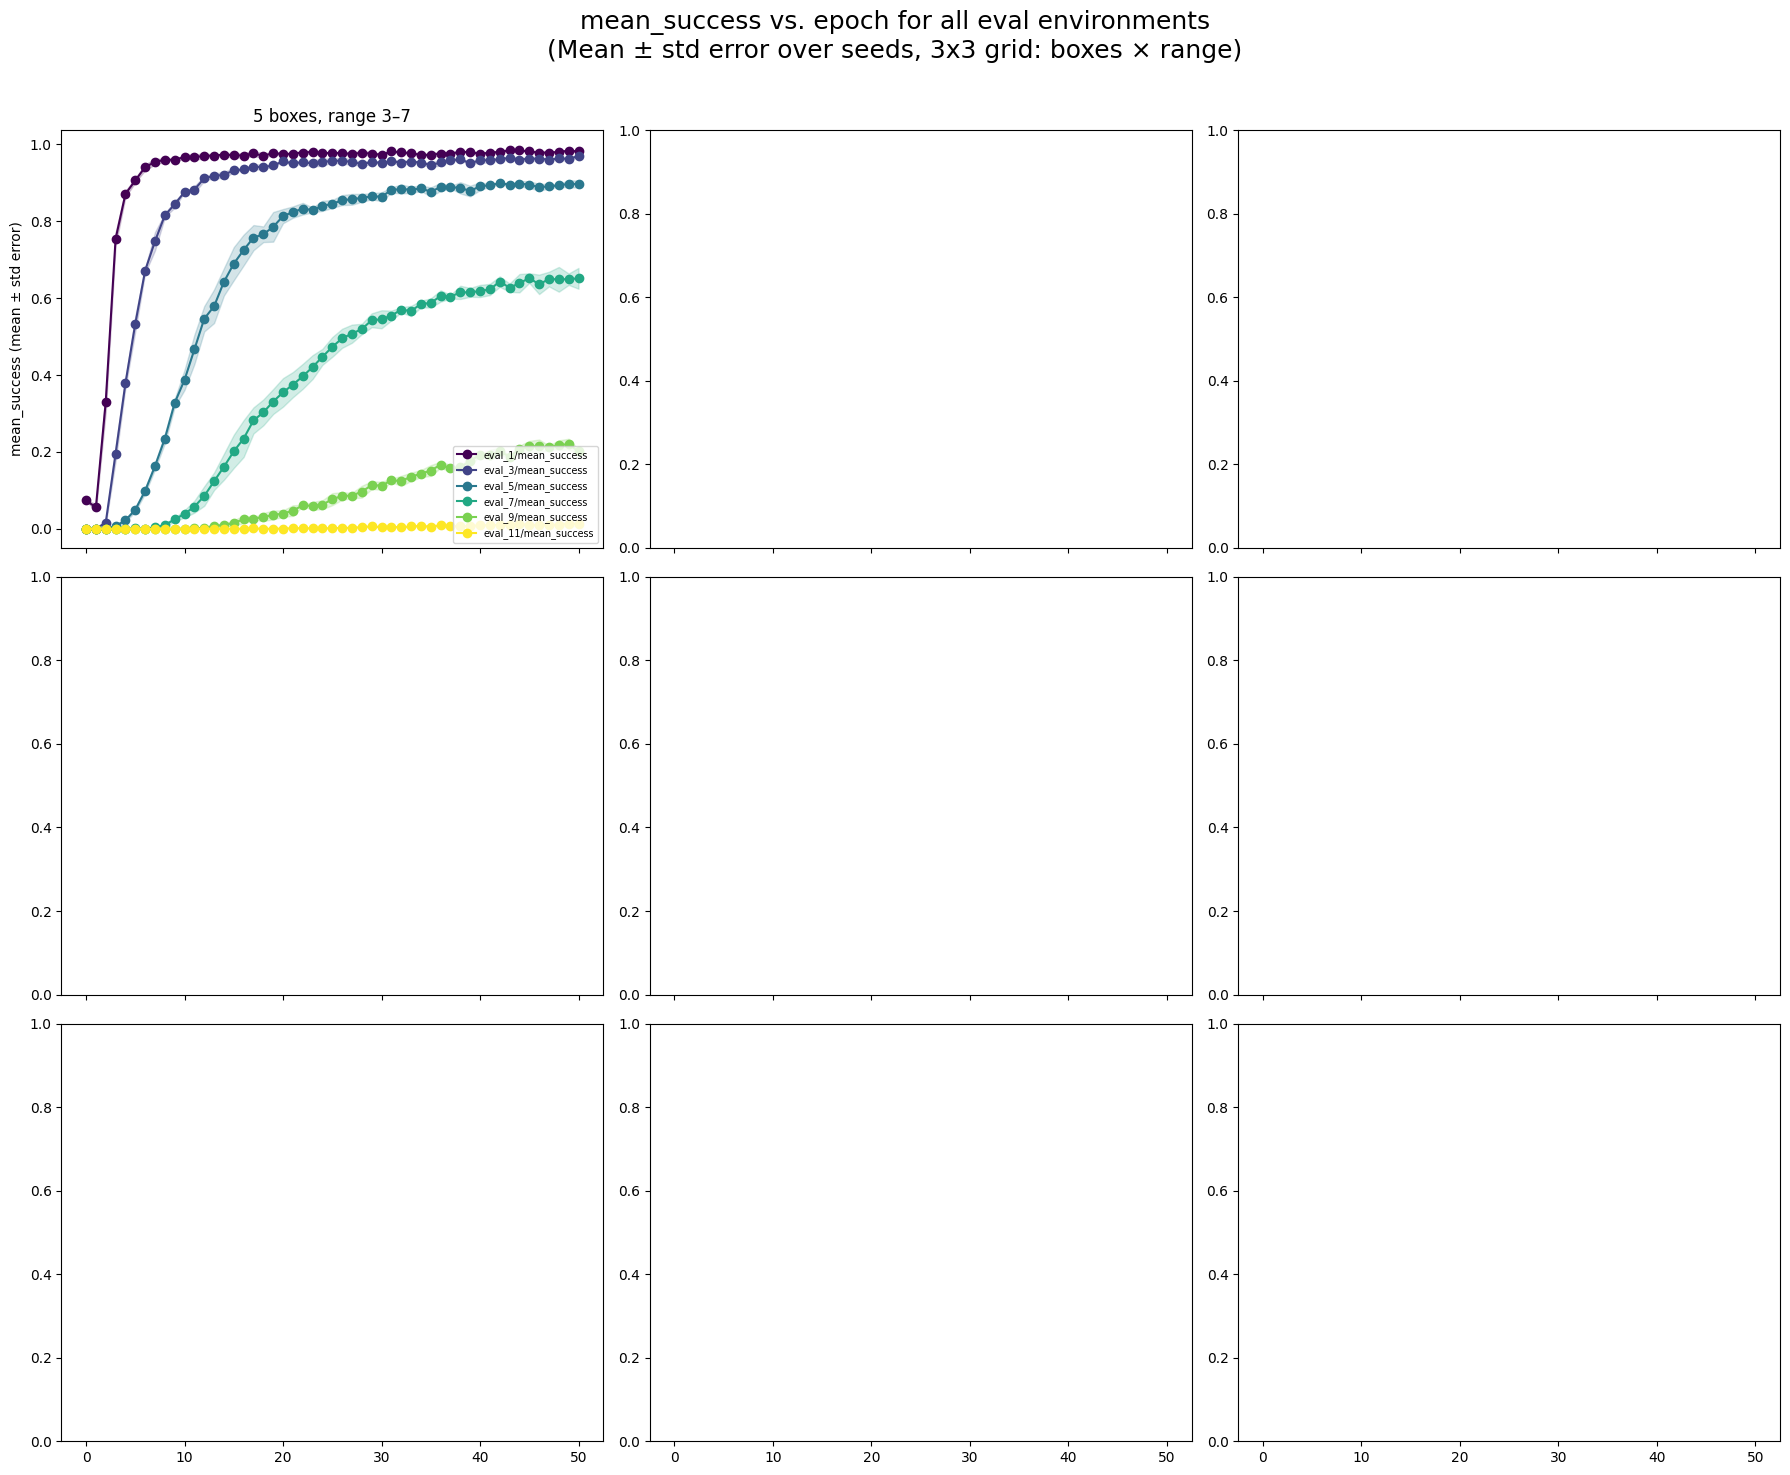

In [12]:
# Metrics to plot (all eval_x/cat_acc keys, or change to e.g. eval_x/mean_reward)
metric_name = "mean_success"  # <-- Change this to your desired metric!
eval_keys = [f"eval_{i}/{metric_name}" for i in [1, 3, 5, 7, 9, 11]]

# Download data (run once, or cache as needed)
data = download_wandb_data(entity, project, boxes_list, range_list, eval_keys, grid=5, run_name='deep_critic_softmax_q_data_collection_moving_boxes_5_grid_5_range_3_7_alpha_0.1')

# Plot using the downloaded data
plot_metric_grid(data, boxes_list, range_list, eval_keys, metric_name=metric_name)


In [5]:
data

{5: {'3_7': []}}

# Polts first tests

In [ ]:
# --- Usage Example ---

# Project and entity info
entity = "cl-probing"
project = "generalization_proper"

# Define grid: rows = number of boxes, columns = range
boxes_list = [3, 5, 7]
range_list = ["5_5", "4_6", "3_7"]  # left to right: narrowest to widest


Run name: moving_boxes_3_grid_5_range_5_5


Run name: moving_boxes_3_grid_5_range_4_6
Run name: moving_boxes_3_grid_5_range_3_7
Run name: moving_boxes_5_grid_5_range_5_5
Run name: moving_boxes_5_grid_5_range_4_6
Run name: moving_boxes_5_grid_5_range_3_7
Run name: moving_boxes_7_grid_5_range_5_5
Run name: moving_boxes_7_grid_5_range_4_6
Run name: moving_boxes_7_grid_5_range_3_7


/tmp/ipykernel_3540537/4190261504.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', num_keys)


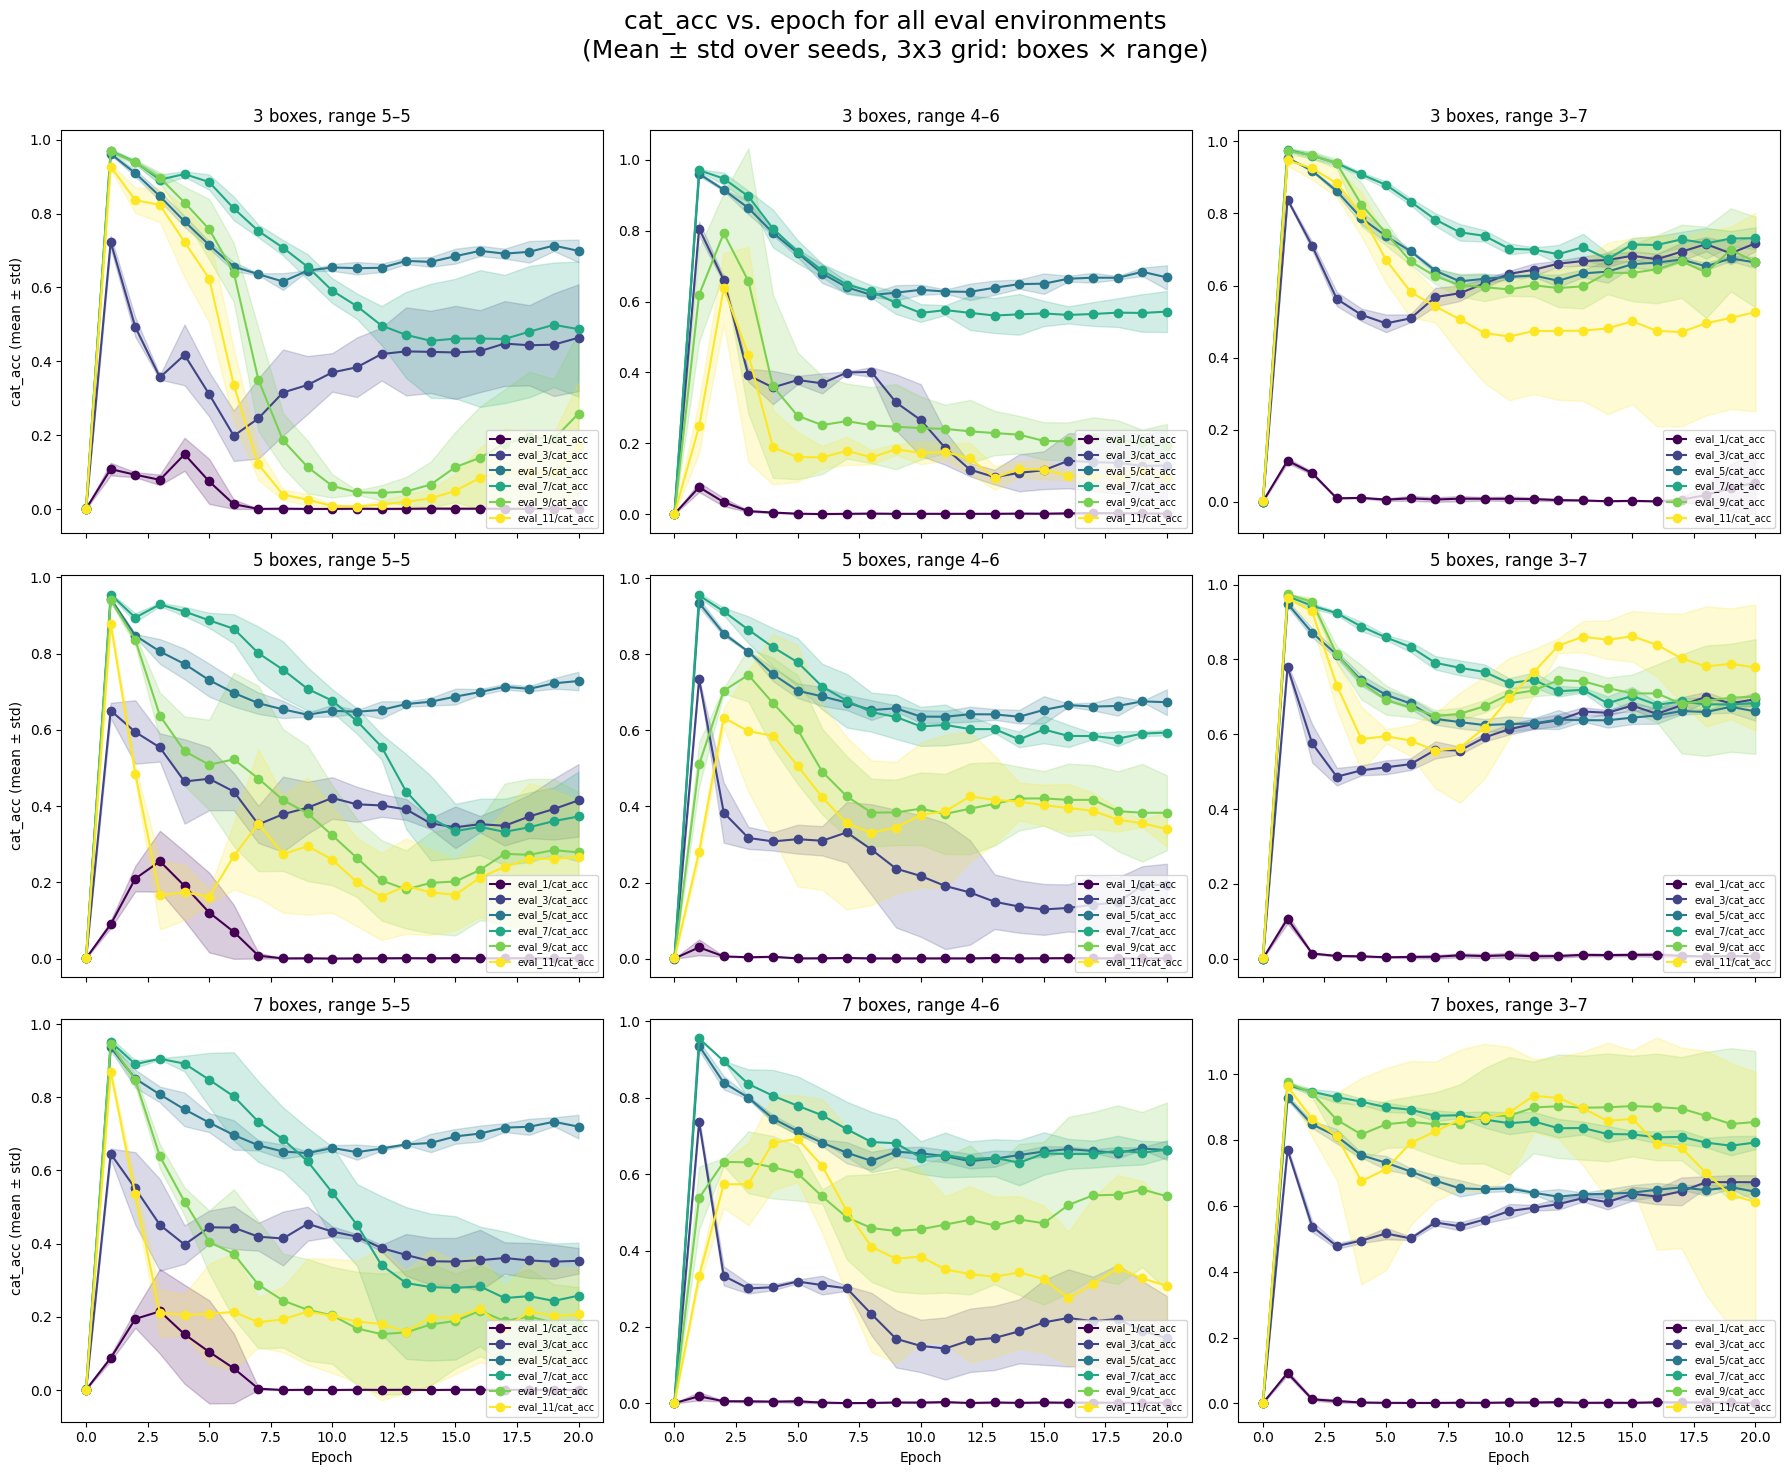

In [2]:
# Metrics to plot (all eval_x/cat_acc keys, or change to e.g. eval_x/mean_reward)
metric_name = "cat_acc"  # <-- Change this to your desired metric!
eval_keys = [f"eval_{i}/{metric_name}" for i in [1, 3, 5, 7, 9, 11]]

# Download data (run once, or cache as needed)
data = download_wandb_data(entity, project, boxes_list, range_list, eval_keys, grid=5)

# Plot using the downloaded data
plot_metric_grid(data, boxes_list, range_list, eval_keys, metric_name=metric_name)


Run name: moving_boxes_3_grid_5_range_5_5


Run name: moving_boxes_3_grid_5_range_4_6
Run name: moving_boxes_3_grid_5_range_3_7
Run name: moving_boxes_5_grid_5_range_5_5
Run name: moving_boxes_5_grid_5_range_4_6
Run name: moving_boxes_5_grid_5_range_3_7
Run name: moving_boxes_7_grid_5_range_5_5
Run name: moving_boxes_7_grid_5_range_4_6
Run name: moving_boxes_7_grid_5_range_3_7


/tmp/ipykernel_3540537/2713264917.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', num_keys)


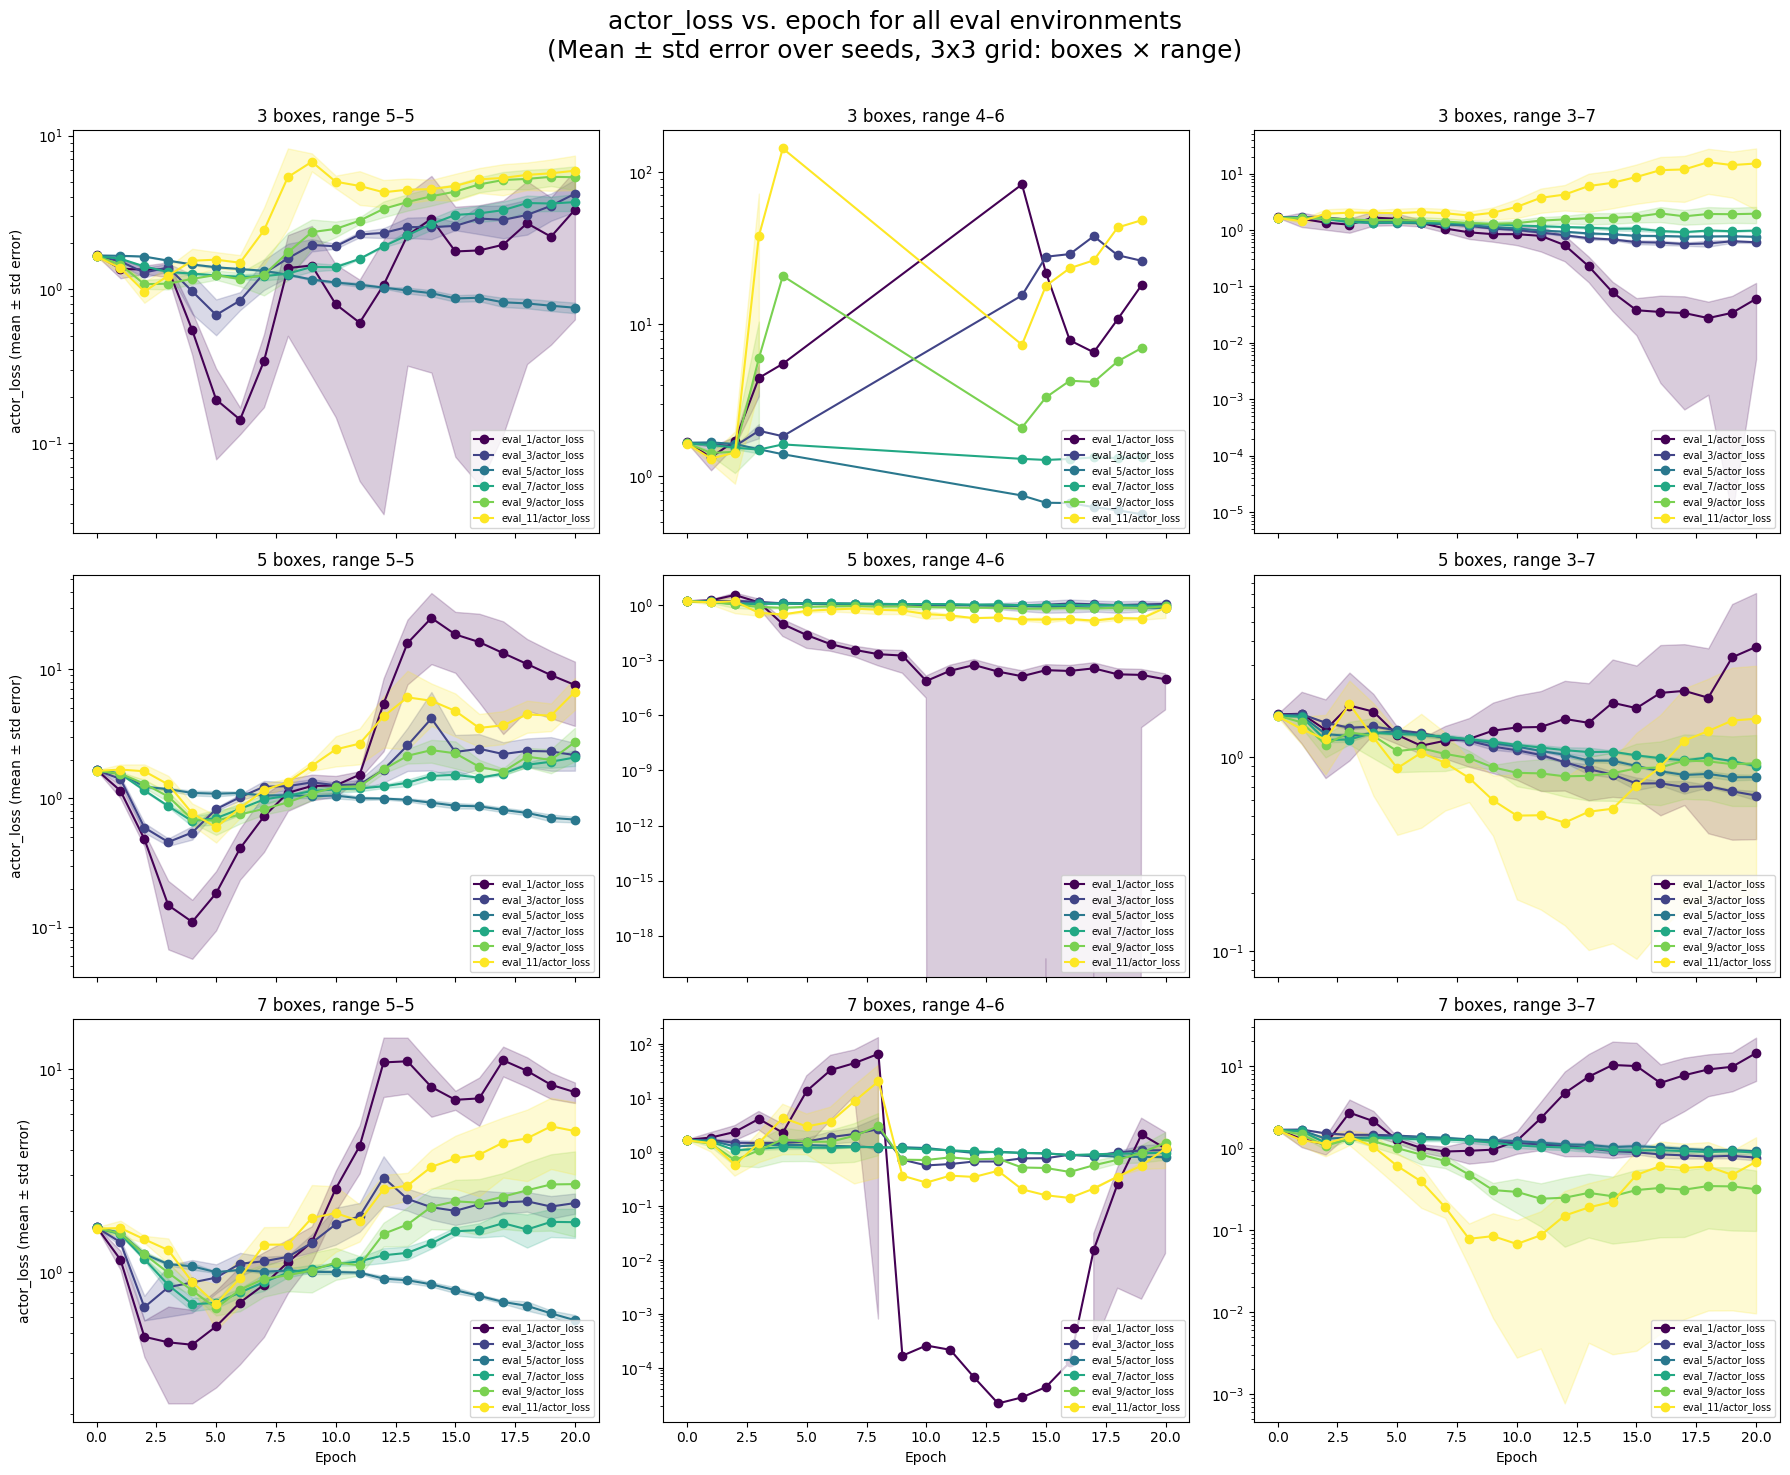

In [7]:
# Metrics to plot (all eval_x/cat_acc keys, or change to e.g. eval_x/mean_reward)
metric_name = "actor_loss"  # <-- Change this to your desired metric!
eval_keys = [f"eval_{i}/{metric_name}" for i in [1, 3, 5, 7, 9, 11]]

# Download data (run once, or cache as needed)
data = download_wandb_data(entity, project, boxes_list, range_list, eval_keys, grid=5)

# Plot using the downloaded data
plot_metric_grid(data, boxes_list, range_list, eval_keys, metric_name=metric_name, log_y=True)


Run name: moving_boxes_3_grid_5_range_5_5


Run name: moving_boxes_3_grid_5_range_4_6
Run name: moving_boxes_3_grid_5_range_3_7
Run name: moving_boxes_5_grid_5_range_5_5
Run name: moving_boxes_5_grid_5_range_4_6
Run name: moving_boxes_5_grid_5_range_3_7
Run name: moving_boxes_7_grid_5_range_5_5
Run name: moving_boxes_7_grid_5_range_4_6
Run name: moving_boxes_7_grid_5_range_3_7


/tmp/ipykernel_3540537/2713264917.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', num_keys)


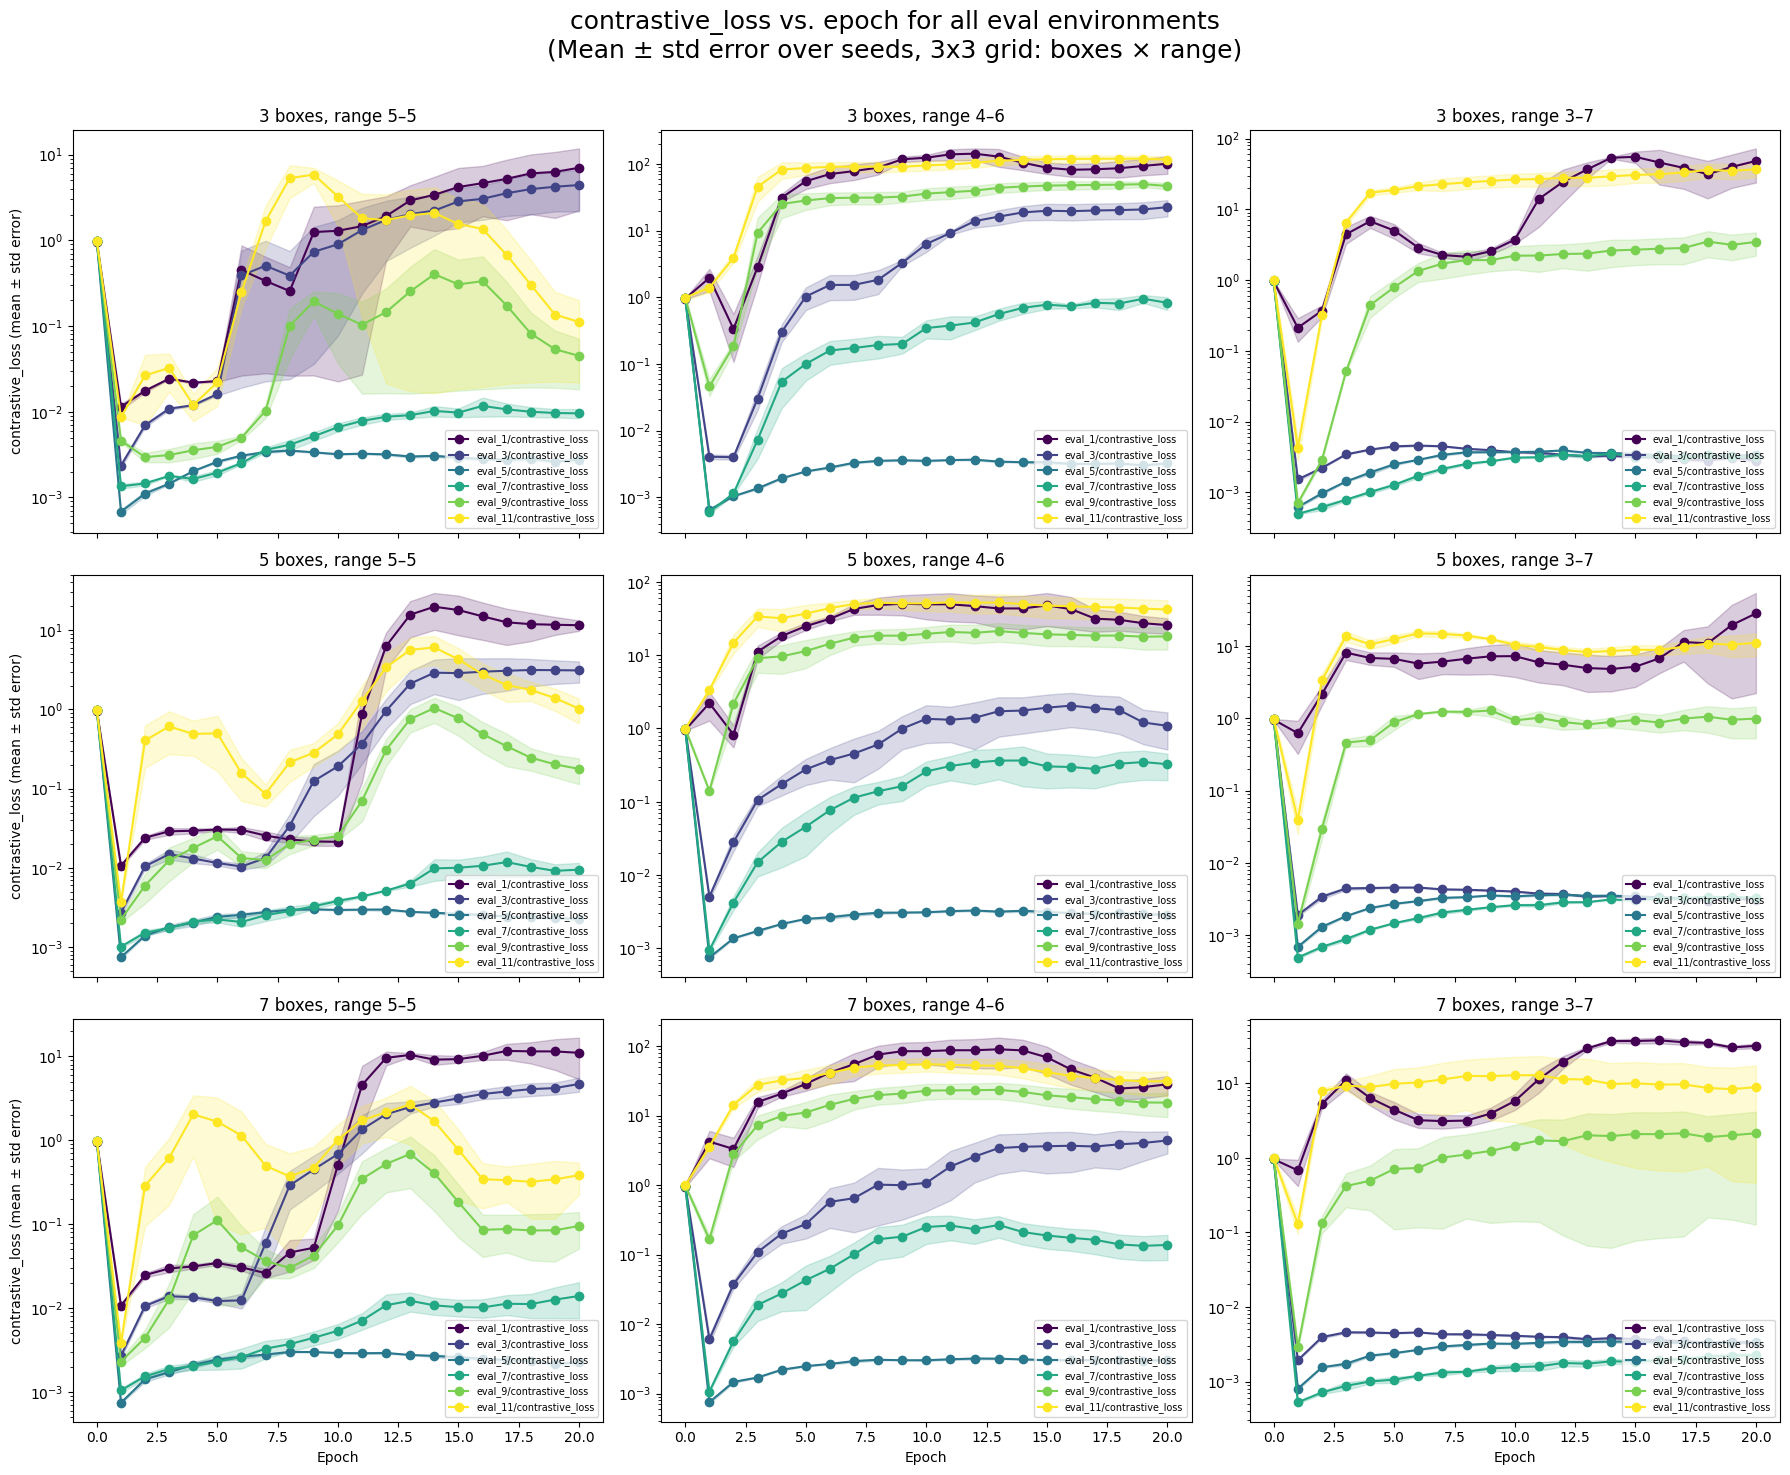

In [8]:
# Metrics to plot (all eval_x/cat_acc keys, or change to e.g. eval_x/mean_reward)
metric_name = "contrastive_loss"  # <-- Change this to your desired metric!
eval_keys = [f"eval_{i}/{metric_name}" for i in [1, 3, 5, 7, 9, 11]]

# Download data (run once, or cache as needed)
data = download_wandb_data(entity, project, boxes_list, range_list, eval_keys, grid=5)

# Plot using the downloaded data
plot_metric_grid(data, boxes_list, range_list, eval_keys, metric_name=metric_name, log_y=True)


Run name: moving_boxes_3_grid_5_range_5_5


Run name: moving_boxes_3_grid_5_range_4_6
Run name: moving_boxes_3_grid_5_range_3_7
Run name: moving_boxes_5_grid_5_range_5_5
Run name: moving_boxes_5_grid_5_range_4_6
Run name: moving_boxes_5_grid_5_range_3_7
Run name: moving_boxes_7_grid_5_range_5_5
Run name: moving_boxes_7_grid_5_range_4_6
Run name: moving_boxes_7_grid_5_range_3_7


/tmp/ipykernel_3540537/4190261504.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', num_keys)


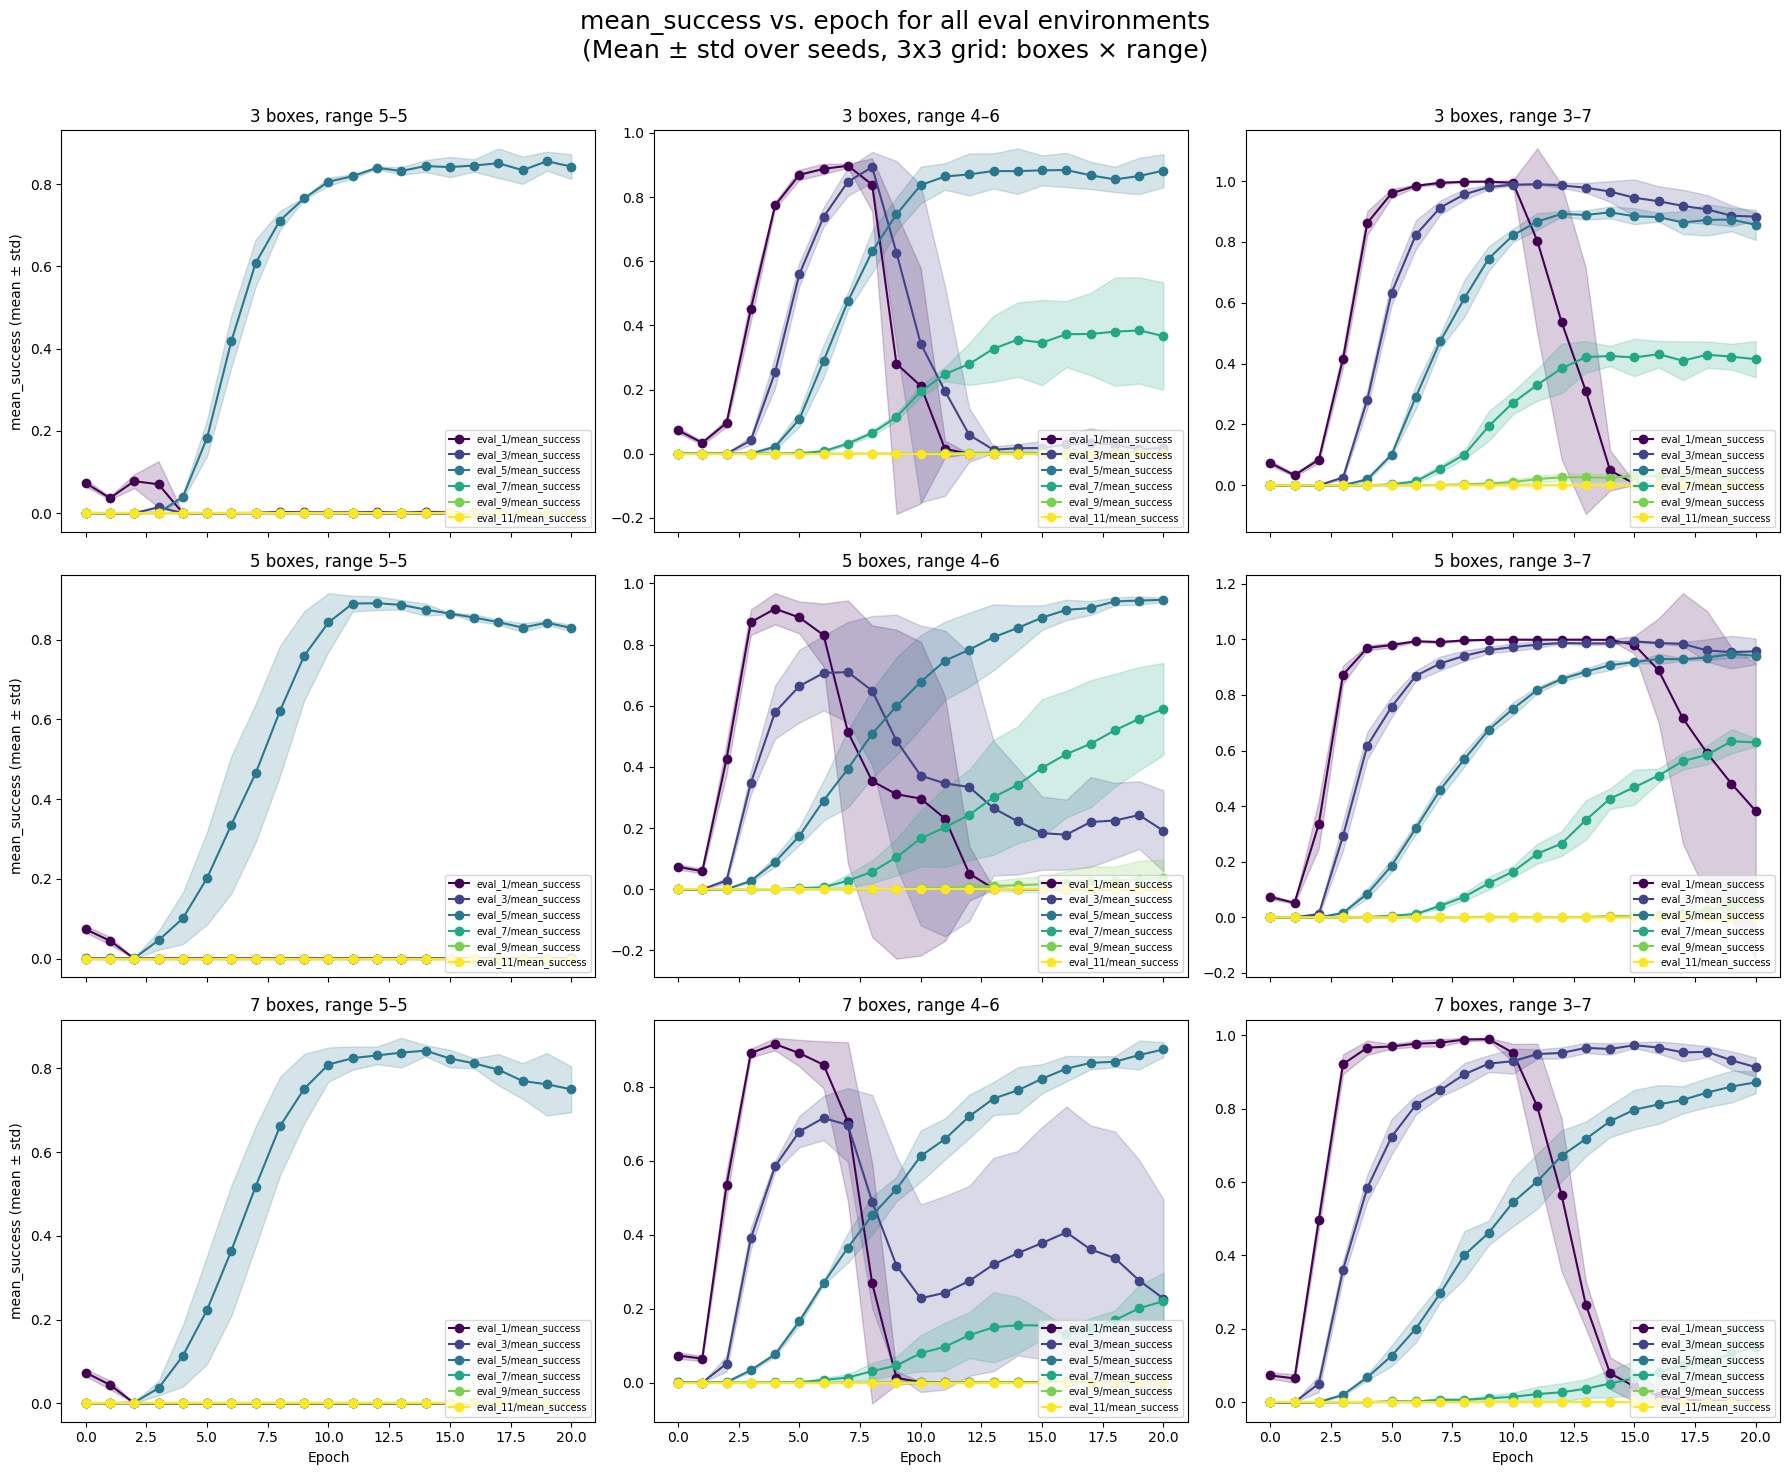

In [5]:
# Metrics to plot (all eval_x/cat_acc keys, or change to e.g. eval_x/mean_reward)
metric_name = "mean_success"  # <-- Change this to your desired metric!
eval_keys = [f"eval_{i}/{metric_name}" for i in [1, 3, 5, 7, 9, 11]]

# Download data (run once, or cache as needed)
data = download_wandb_data(entity, project, boxes_list, range_list, eval_keys, grid=5)

# Plot using the downloaded data
plot_metric_grid(data, boxes_list, range_list, eval_keys, metric_name=metric_name)


# IQL

Run name: moving_boxes_3_grid_5_range_5_5
Run name: moving_boxes_3_grid_5_range_4_6
Run name: moving_boxes_3_grid_5_range_3_7
Run name: moving_boxes_5_grid_5_range_5_5
Run name: moving_boxes_5_grid_5_range_4_6
Run name: moving_boxes_5_grid_5_range_3_7
Run name: moving_boxes_7_grid_5_range_5_5
Run name: moving_boxes_7_grid_5_range_4_6
Run name: moving_boxes_7_grid_5_range_3_7


/tmp/ipykernel_3540537/2713264917.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', num_keys)


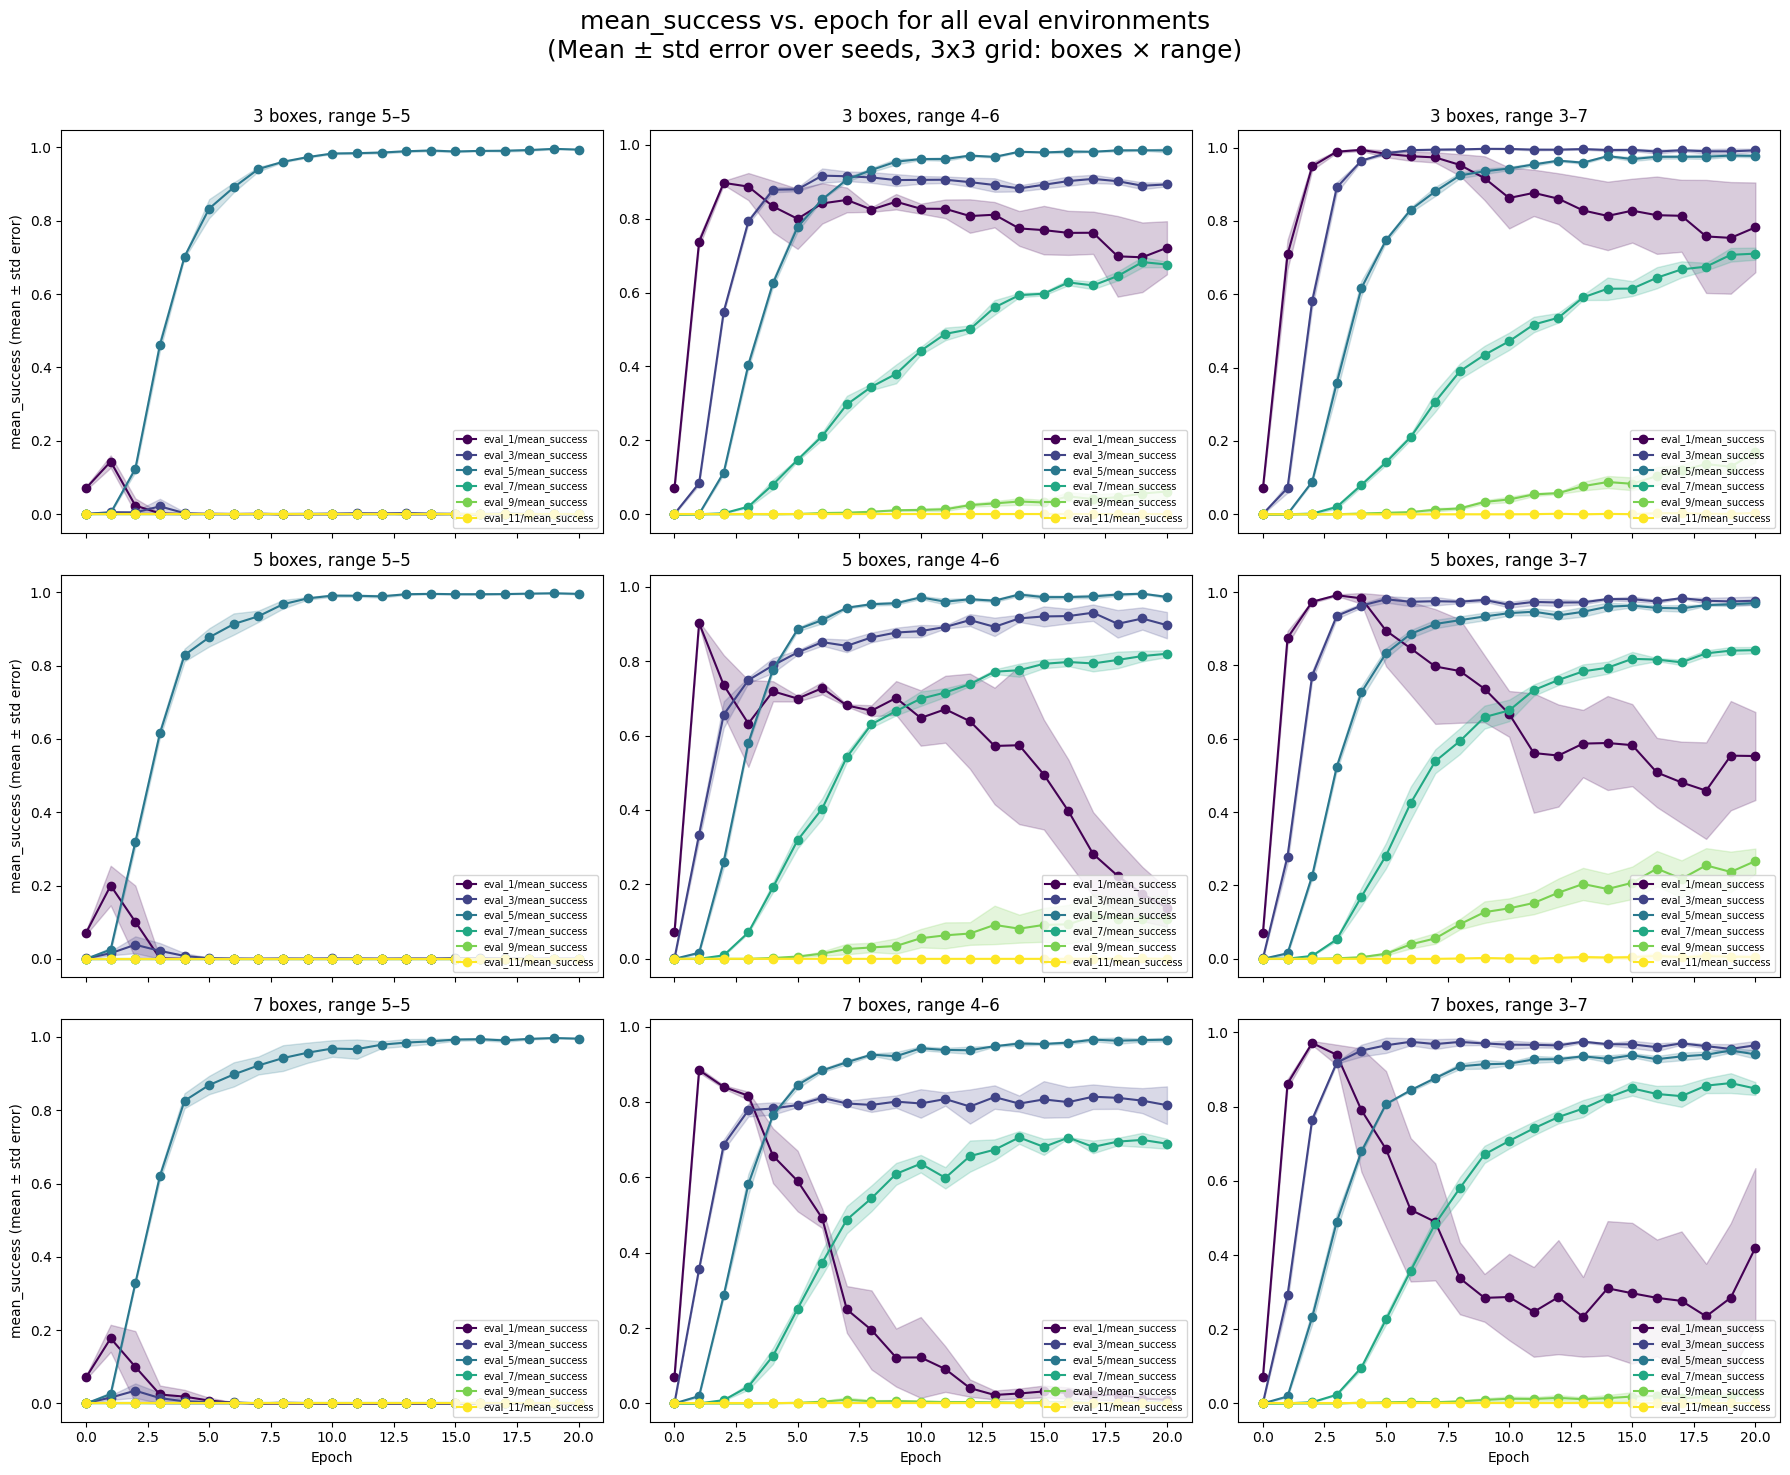

In [ ]:
# Metrics to plot (all eval_x/cat_acc keys, or change to e.g. eval_x/mean_reward)
metric_name = "mean_success"  # <-- Change this to your desired metric!
eval_keys = [f"eval_{i}/{metric_name}" for i in [1, 3, 5, 7, 9, 11]]
project = "generalization_proper_iql"

# Download data (run once, or cache as needed)
data = download_wandb_data(entity, project, boxes_list, range_list, eval_keys, grid=5)

# Plot using the downloaded data
plot_metric_grid(data, boxes_list, range_list, eval_keys, metric_name=metric_name)


Run name: moving_boxes_3_grid_5_range_5_5
Run name: moving_boxes_3_grid_5_range_4_6
Run name: moving_boxes_3_grid_5_range_3_7
Run name: moving_boxes_5_grid_5_range_5_5
Run name: moving_boxes_5_grid_5_range_4_6
Run name: moving_boxes_5_grid_5_range_3_7
Run name: moving_boxes_7_grid_5_range_5_5
Run name: moving_boxes_7_grid_5_range_4_6
Run name: moving_boxes_7_grid_5_range_3_7


/tmp/ipykernel_3540537/2713264917.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', num_keys)


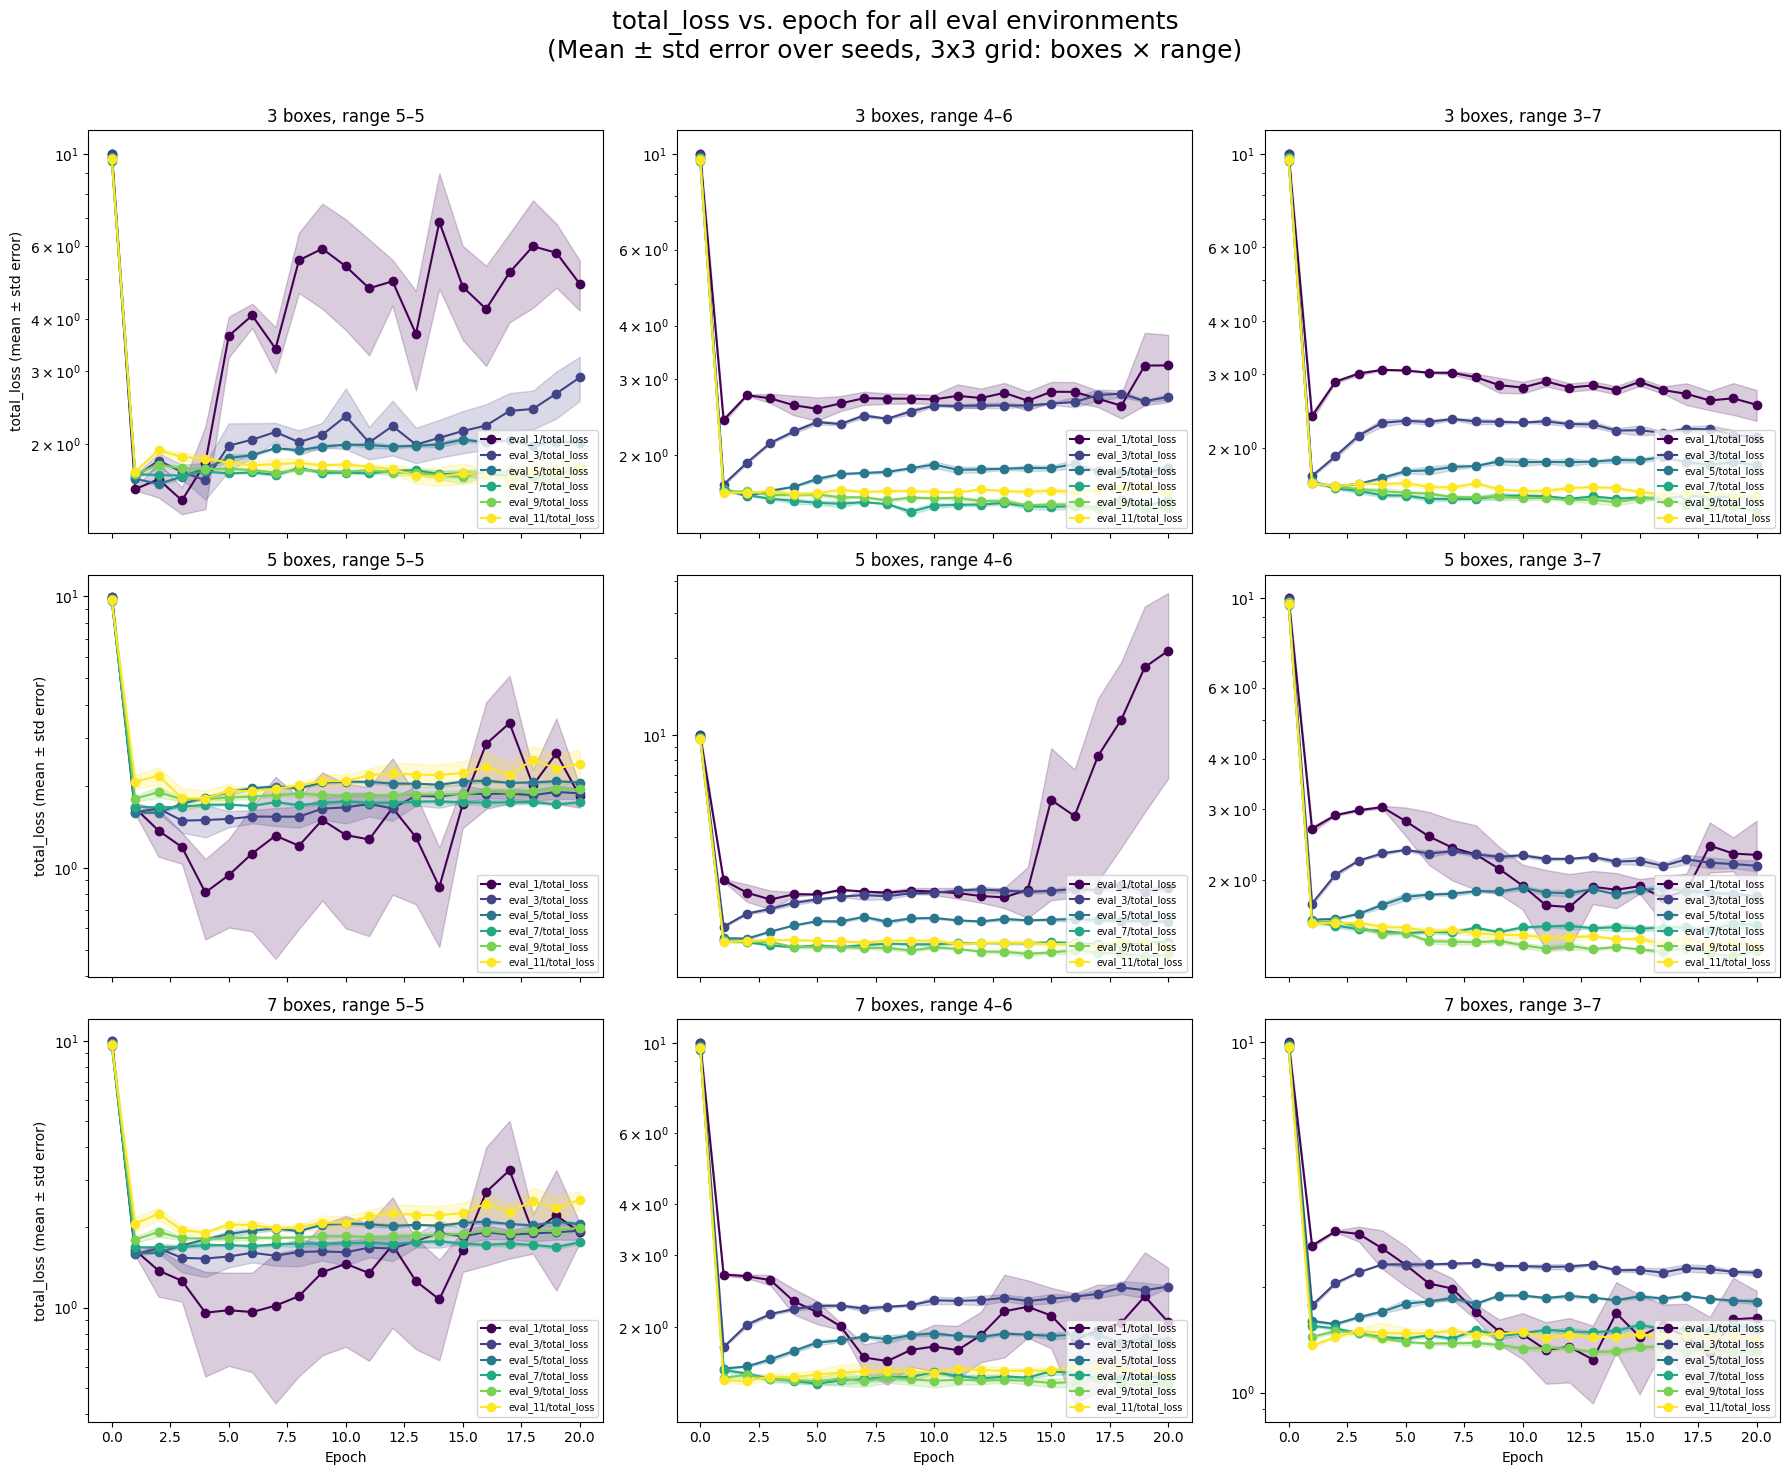

In [10]:
# Metrics to plot (all eval_x/cat_acc keys, or change to e.g. eval_x/mean_reward)
metric_name = "total_loss"  # <-- Change this to your desired metric!
eval_keys = [f"eval_{i}/{metric_name}" for i in [1, 3, 5, 7, 9, 11]]
project = "generalization_proper_iql"

# Download data (run once, or cache as needed)
data = download_wandb_data(entity, project, boxes_list, range_list, eval_keys, grid=5)

# Plot using the downloaded data
plot_metric_grid(data, boxes_list, range_list, eval_keys, metric_name=metric_name, log_y=True)
